# 10 — Backprop and Gradient Descent

Purpose: implement a small MLP end-to-end (forward, loss, backward, update) with correct shapes, stable cross-entropy from logits, and gradient checking by finite differences.

## Learning goals
- Implement forward pass for a 2-layer MLP using `x, W, b, z, a` conventions.
- Implement stable binary and multiclass cross-entropy from logits.
- Implement backward pass (backprop) and update with gradient descent.
- Print shapes at key steps to debug.
- Verify gradients with finite-difference gradient checking.

## Prerequisites
- Notebook 06 (stable losses from logits).
- Notebook 09 (scaling helps).
- Comfort with NumPy matrix ops and careful shape tracking.

## Key ideas
- Backprop is just the chain rule applied to arrays.
- Stable loss implementations prevent NaNs.
- Gradient checking catches sign/shape mistakes early.
- If gradients are correct, optimization issues are usually about scaling or learning rate.

## Minimal theory
- For softmax cross-entropy, the gradient w.r.t. logits is `(p - y_onehot)/N`.
- For sigmoid+BCE, gradient w.r.t. logits is also `(sigmoid(z) - y)/N`.
- ReLU gradient: multiply by `(z>0)` mask.
- Gradient checking compares analytical gradients to finite differences:
  `dL/dθ ≈ (L(θ+ε) - L(θ-ε)) / (2ε)`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def relu(z):
    return np.maximum(0.0, z)

def drelu(z):
    return (z > 0).astype(float)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def softmax_logsumexp(z):
    m = np.max(z, axis=1, keepdims=True)
    exp = np.exp(z - m)
    return exp / np.sum(exp, axis=1, keepdims=True)

def bce_from_logits(z, y):
    t = np.maximum(z, 0) - z*y + np.log1p(np.exp(-np.abs(z)))
    return float(np.mean(t))

def softmax_ce_from_logits(z, y_onehot):
    m = np.max(z, axis=1, keepdims=True)
    logsumexp = m + np.log(np.sum(np.exp(z - m), axis=1, keepdims=True))
    log_softmax = z - logsumexp
    return float(-np.mean(np.sum(y_onehot * log_softmax, axis=1, keepdims=True)))

def standardize_fit(x):
    mu = x.mean(axis=0, keepdims=True)
    sigma = x.std(axis=0, keepdims=True) + 1e-12
    return mu, sigma

def standardize_apply(x, mu, sigma):
    return (x - mu) / sigma

print('Ready.')

Ready.


## Step-by-step experiments
1. Create a small 3-class 2D dataset (deterministic) and one-hot targets.
2. Implement forward pass for a 2-layer MLP: `(2->H->3)`.
3. Implement softmax CE loss (from logits) and backward pass.
4. Run gradient checking on a few parameters.
5. Train with gradient descent and visualize decision regions + loss curve.

x_tr: (675, 2) y_tr_oh: (675, 3)
x_va: (225, 2) y_va_oh: (225, 3)


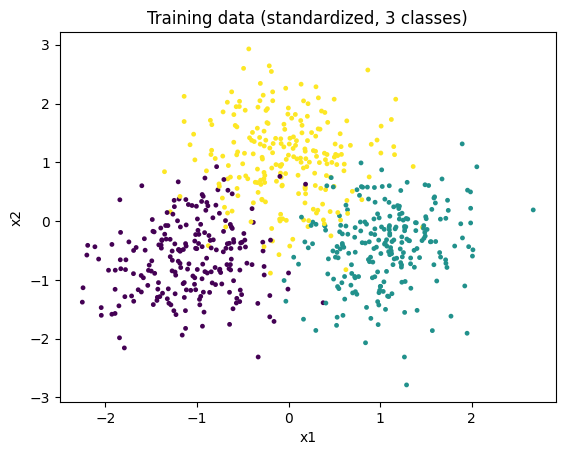

In [2]:
def make_3class_blobs(N=900, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    n = N // 3
    x0 = rng.normal(loc=(-1.2, 0.0), scale=0.55, size=(n,2))
    x1 = rng.normal(loc=(+1.2, 0.2), scale=0.55, size=(n,2))
    x2 = rng.normal(loc=(0.0, 1.4), scale=0.55, size=(n,2))
    x = np.vstack([x0, x1, x2])
    y_idx = np.array([0]*n + [1]*n + [2]*n)
    idx = rng.permutation(N)
    return x[idx], y_idx[idx]

x, y_idx = make_3class_blobs(N=900, rng=rng)
C = 3
y_onehot = np.zeros((x.shape[0], C))
y_onehot[np.arange(x.shape[0]), y_idx] = 1.0

# standardize (train-only fit later; here we do a single split first)
def split_train_val(x, y_idx, y_onehot, val_ratio=0.25, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    N = x.shape[0]
    idx = rng.permutation(N)
    n_val = int(N*val_ratio)
    va = idx[:n_val]
    tr = idx[n_val:]
    return x[tr], y_idx[tr], y_onehot[tr], x[va], y_idx[va], y_onehot[va]

x_tr, y_tr_idx, y_tr_oh, x_va, y_va_idx, y_va_oh = split_train_val(x, y_idx, y_onehot, rng=rng)
mu, sig = standardize_fit(x_tr)
x_tr = standardize_apply(x_tr, mu, sig)
x_va = standardize_apply(x_va, mu, sig)

print('x_tr:', x_tr.shape, 'y_tr_oh:', y_tr_oh.shape)
print('x_va:', x_va.shape, 'y_va_oh:', y_va_oh.shape)

plt.figure()
plt.scatter(x_tr[:,0], x_tr[:,1], c=y_tr_idx, s=12, edgecolors='none')
plt.title('Training data (standardized, 3 classes)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [3]:
# MLP: 2 -> H -> 3
H = 24
D = 2

W1 = rng.normal(0, 0.4, size=(D,H))
b1 = np.zeros((1,H))
W2 = rng.normal(0, 0.4, size=(H,C))
b2 = np.zeros((1,C))

def forward(x, W1, b1, W2, b2):
    z1 = x @ W1 + b1         # (N,H)
    a1 = relu(z1)            # (N,H)
    z2 = a1 @ W2 + b2        # (N,C) logits
    return z1, a1, z2

def loss_and_grads(x, y_onehot, W1, b1, W2, b2, l2=0.0):
    N = x.shape[0]
    z1, a1, z2 = forward(x, W1, b1, W2, b2)
    p = softmax_logsumexp(z2)
    L = softmax_ce_from_logits(z2, y_onehot) + l2*(np.sum(W1*W1)+np.sum(W2*W2))

    # backward
    dz2 = (p - y_onehot) / N              # (N,C)
    dW2 = a1.T @ dz2 + 2*l2*W2            # (H,C)
    db2 = np.sum(dz2, axis=0, keepdims=True)  # (1,C)
    da1 = dz2 @ W2.T                      # (N,H)
    dz1 = da1 * drelu(z1)                 # (N,H)
    dW1 = x.T @ dz1 + 2*l2*W1             # (D,H)
    db1 = np.sum(dz1, axis=0, keepdims=True)  # (1,H)

    cache = {
        'z1': z1, 'a1': a1, 'z2': z2,
        'p': p
    }
    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    return L, cache, grads

L0, cache0, grads0 = loss_and_grads(x_tr[:10], y_tr_oh[:10], W1, b1, W2, b2)
print('Sanity forward shapes:')
print('z1:', cache0['z1'].shape, 'a1:', cache0['a1'].shape, 'z2:', cache0['z2'].shape)
print('p :', cache0['p'].shape)
print('Grad shapes:')
for k,v in grads0.items():
    print(k, v.shape)
print('Initial minibatch loss:', L0)

Sanity forward shapes:
z1: (10, 24) a1: (10, 24) z2: (10, 3)
p : (10, 3)
Grad shapes:
dW1 (2, 24)
db1 (1, 24)
dW2 (24, 3)
db2 (1, 3)
Initial minibatch loss: 2.0668499116192196


In [4]:
# Gradient checking (finite differences)
def grad_check_param(x, y_onehot, W1, b1, W2, b2, param_name, idx_tuple, eps=1e-5):
    # Get analytical
    L, _, grads = loss_and_grads(x, y_onehot, W1, b1, W2, b2)
    if param_name == 'W1':
        ana = grads['dW1'][idx_tuple]
        ref = W1
    elif param_name == 'b1':
        ana = grads['db1'][idx_tuple]
        ref = b1
    elif param_name == 'W2':
        ana = grads['dW2'][idx_tuple]
        ref = W2
    elif param_name == 'b2':
        ana = grads['db2'][idx_tuple]
        ref = b2
    else:
        raise ValueError('param_name')

    old = ref[idx_tuple]
    ref[idx_tuple] = old + eps
    Lp, _, _ = loss_and_grads(x, y_onehot, W1, b1, W2, b2)
    ref[idx_tuple] = old - eps
    Lm, _, _ = loss_and_grads(x, y_onehot, W1, b1, W2, b2)
    ref[idx_tuple] = old
    num = (Lp - Lm) / (2*eps)
    return float(ana), float(num), float(abs(ana-num) / (abs(ana)+abs(num)+1e-12))

x_chk = x_tr[:40]
y_chk = y_tr_oh[:40]

tests = [
    ('W1', (0, 0)),
    ('W1', (1, 5)),
    ('b1', (0, 3)),
    ('W2', (2, 1)),
    ('b2', (0, 2)),
]

for name, idx_t in tests:
    ana, num, rel = grad_check_param(x_chk, y_chk, W1, b1, W2, b2, name, idx_t)
    print(f'{name}{idx_t}: analytic={ana:.6e}, numeric={num:.6e}, rel_err={rel:.3e}')

W1(0, 0): analytic=-8.806517e-03, numeric=-8.806517e-03, rel_err=4.260e-11
W1(1, 5): analytic=6.963730e-02, numeric=6.963730e-02, rel_err=6.092e-11
b1(0, 3): analytic=-2.077834e-01, numeric=-2.077834e-01, rel_err=1.161e-12
W2(2, 1): analytic=1.109655e-02, numeric=1.109655e-02, rel_err=2.094e-10
b2(0, 2): analytic=-4.686260e-02, numeric=-4.686260e-02, rel_err=2.158e-11


step 200 train L 0.1832152562655496 val L 0.2550058854337482
step 400 train L 0.18107043731721853 val L 0.25638242149527907
step 600 train L 0.18017806947107778 val L 0.2567742535900738
step 800 train L 0.17968099147319683 val L 0.2570753183486288
step 1000 train L 0.17932116576369947 val L 0.2574091037763018
step 1200 train L 0.17892031602827804 val L 0.2576433767392037


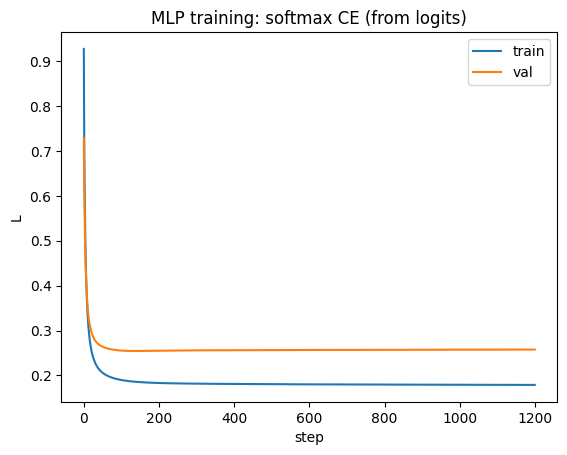

Validation accuracy: 0.8933333333333333


In [5]:
# Training loop (full-batch for simplicity and determinism)
def train_mlp(x_tr, y_tr_oh, x_va, y_va_oh, H=24, lr=0.2, steps=1200, l2=1e-4):
    D = x_tr.shape[1]
    C = y_tr_oh.shape[1]
    W1 = rng.normal(0, 0.4, size=(D,H))
    b1 = np.zeros((1,H))
    W2 = rng.normal(0, 0.4, size=(H,C))
    b2 = np.zeros((1,C))
    trL, vaL = [], []
    for step in range(steps):
        L, _, grads = loss_and_grads(x_tr, y_tr_oh, W1, b1, W2, b2, l2=l2)
        W1 -= lr*grads['dW1']
        b1 -= lr*grads['db1']
        W2 -= lr*grads['dW2']
        b2 -= lr*grads['db2']
        trL.append(L)
        Lv, _, _ = loss_and_grads(x_va, y_va_oh, W1, b1, W2, b2, l2=l2)
        vaL.append(Lv)
        if (step+1) % 200 == 0:
            print('step', step+1, 'train L', trL[-1], 'val L', vaL[-1])
    return W1, b1, W2, b2, np.array(trL), np.array(vaL)

W1t, b1t, W2t, b2t, trL, vaL = train_mlp(x_tr, y_tr_oh, x_va, y_va_oh, H=24, lr=0.25, steps=1200, l2=1e-4)

# Plot 1: loss curves
plt.figure()
plt.plot(trL, label='train')
plt.plot(vaL, label='val')
plt.title('MLP training: softmax CE (from logits)')
plt.xlabel('step')
plt.ylabel('L')
plt.legend()
plt.show()

def predict_class(x, W1, b1, W2, b2):
    _, _, z2 = forward(x, W1, b1, W2, b2)
    p = softmax_logsumexp(z2)
    return np.argmax(p, axis=1)

pred_va = predict_class(x_va, W1t, b1t, W2t, b2t)
acc_va = float((pred_va == y_va_idx).mean())
print('Validation accuracy:', acc_va)

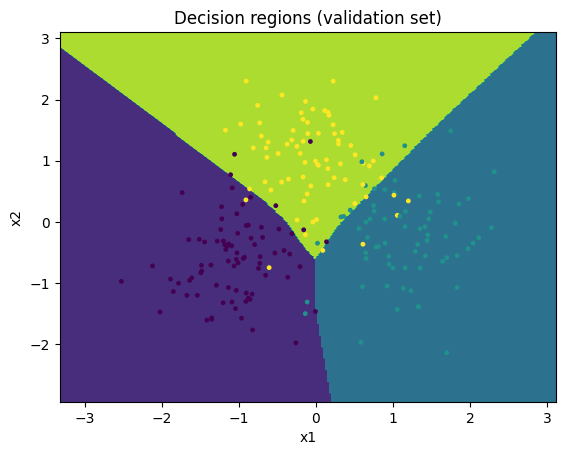

In [6]:
# Plot 2: decision regions
def plot_regions(x, y_idx, W1, b1, W2, b2, title):
    x1_min, x1_max = x[:,0].min()-0.8, x[:,0].max()+0.8
    x2_min, x2_max = x[:,1].min()-0.8, x[:,1].max()+0.8
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 250), np.linspace(x2_min, x2_max, 250))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    pred = predict_class(grid, W1, b1, W2, b2).reshape(xx1.shape)
    plt.figure()
    plt.contourf(xx1, xx2, pred, levels=3)
    plt.scatter(x[:,0], x[:,1], c=y_idx, s=12, edgecolors='none')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

plot_regions(x_va, y_va_idx, W1t, b1t, W2t, b2t, 'Decision regions (validation set)')

## Reflection questions
1. Why does `(p - y_onehot)/N` appear as the gradient for softmax CE?
2. What is the role of the ReLU mask in backprop?
3. Which parameter gradients were most sensitive in gradient checking, and why?
4. How does standardization affect training speed here?
5. If you increase hidden width, what do you expect to happen to train vs val loss?

## Optional extensions
1. Replace ReLU with tanh and compare training curves.
2. Add mini-batch training (deterministic batches) and compare convergence.
3. Implement a binary version (2->H->1) with BCE-from-logits and compare gradients.

## Summary
- Backprop is the chain rule applied to array operations.
- Stable CE from logits prevents overflow/NaNs.
- Shape prints make debugging tractable.
- Gradient checking validates your implementation.
- With correct gradients, optimization becomes a controlled engineering problem.